In [2]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from sklearn.model_selection import train_test_split
from model.loss_functions.RMSELoss import RMSELoss
from utils.dataset_utils import DatasetUtils

In [3]:
# Define constants
START_DATE_BOARD = '2022-11-03'
END_DATE_BOARD = '2023-06-15'
RANDOM_STATE = 42

## Benchmark Loss
The goal of this notebook is to compute the same loss of the 3 models (LSTM, ANN, VQR) in the same portion of test set. The result will be the benchmark that each model has to overcome.

### LSTM model
Best hyperparams:
- optimizer: ADAM
- criterion: L1
- learning rate: 0.001
- num epochs: 450
- hidden size: 600
- T: 3
- train size: 15%

Final loss on test set: 2.7362

### ANN model
Best hyperparams:
- optmizier: SGD
- criterion: L1
- learning rate: 0.0001
- num epochs: 200
- hidden size: 60
- hidden size layer 2: ?
- hidden size layer 3: ?
- train size: 70%

Final loss on test set: 5.3008

### VQR linear model
Best hyperparams:
- optmizier: Adam
- criterion: MSE
- learning rate: 0.01
- num epochs: 200
- num quantum layer: 4
- batch size: 10 
- train size: 75%

Final loss on test set: 0.0026194

### QLSTM model
Best hyperparams:
- TRAINING SIZE: 0.70 (70%)
- LEARNING RATE: 0.01
- EPOCHS: 400
- HIDDEN SIZE: 15
- T: 5
- QUANTUM LAYERS: 5
- QUBITS: 7
- OPTMIZIER: adam
- CRITERION: l1
- loss / train-set: 5.2021

Final loss on test set: 2.6978

In [4]:
# Define best hyperparams for LSTM
TRAIN_SIZE      = 0.70
CRITERION_L1    = nn.L1Loss()
CRITERION_RMSE  = RMSELoss()
CRITERION_MSE   = nn.MSELoss()

#### Build the same dataset

In [5]:
df_sensors = pd.read_csv('../resources/dataset/unique_timeseries_by_median_hours.csv')
df_sensors.timestamp = pd.to_datetime(df_sensors.timestamp)
df_sensors.timestamp += pd.Timedelta(hours=1)
df_arpa = DatasetUtils.build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv', START_DATE_BOARD, END_DATE_BOARD)

df = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)
# Slide ARPA data 1 hour plus
df['y'] = DatasetUtils.slide_plus_1hours(df['y'], df['x'][0])
X = df.x.values
y = df.y.values
_, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                    shuffle=False,
                                                    random_state=RANDOM_STATE)

#### Compute the loss

In [6]:
CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()

5.029574394226074

In [7]:
CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()

6.521755218505859

In [8]:
CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()

42.53329086303711

In [9]:
# Loss computed on the entire dataset
CRITERION_RMSE(torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32))).item()

9.113276481628418

## Benchmark Loss distribution

### With 30% of test-set

In [10]:
TRAIN_SIZE      = 0.70
df_sensors = pd.read_csv('../resources/dataset/unique_timeseries_by_median_hours.csv')
df_sensors.timestamp = pd.to_datetime(df_sensors.timestamp)
df_sensors.timestamp += pd.Timedelta(hours=1)
df_arpa = DatasetUtils.build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv', START_DATE_BOARD, END_DATE_BOARD)

df = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)
# Slide ARPA data 1 hour plus
df['y'] = DatasetUtils.slide_plus_1hours(df['y'], df['x'][0])
X = df.x.values
y = df.y.values

In [11]:
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

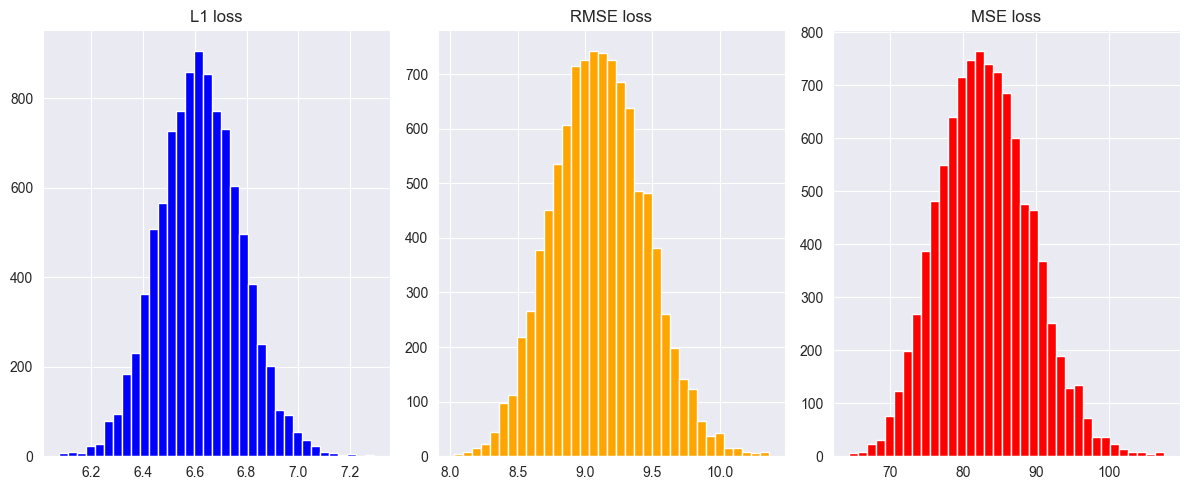

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=35, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=35, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=35, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

### With 25% of test-set

In [13]:
TRAIN_SIZE      = 0.75

In [7]:
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

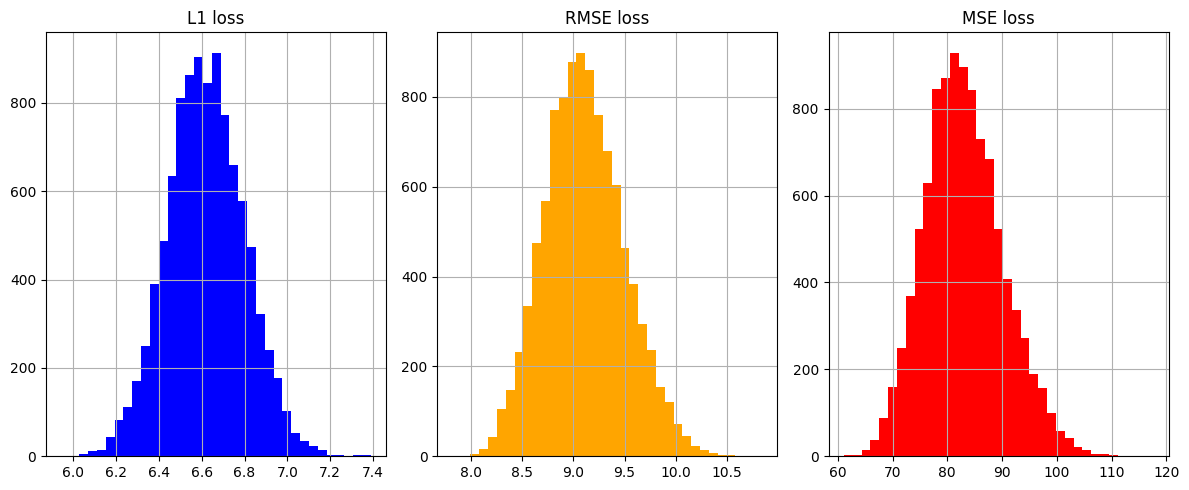

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=35, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=35, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=35, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

### Make the benchmarke loss with the dataset scaled from [-1, +1] in order to compare with VQR

In [8]:
TRAIN_SIZE      = 0.75
# Prepare dataframe
df_scaled = df.drop(['timestamp'], axis=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
rescaledX = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(rescaledX, columns=df_scaled.columns)
X = df_scaled.loc[:, df_scaled.columns != "y"].values
y = df_scaled['y'].values
_, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=False, random_state=RANDOM_STATE)

In [ ]:
print(CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item())
print(CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item())
print(CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item())

In [9]:
TRAIN_SIZE      = 0.75
# Prepare dataframe
df_scaled = df.drop(['timestamp'], axis=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
rescaledX = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(rescaledX, columns=df_scaled.columns)
X = df_scaled.loc[:, df_scaled.columns != "y"].values
y = df_scaled['y'].values
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution_scaled = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution_scaled['l1'] = l1_loss
df_benchmark_distribution_scaled['rmse'] = rmse_loss
df_benchmark_distribution_scaled['mse'] = mse_loss

/Users/lorenzoberhadano/University/Polito/Thesis/quantum_weather_station/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([921])) that is different to the input size (torch.Size([921, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/lorenzoberhadano/University/Polito/Thesis/quantum_weather_station/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([921])) that is different to the input size (torch.Size([921, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


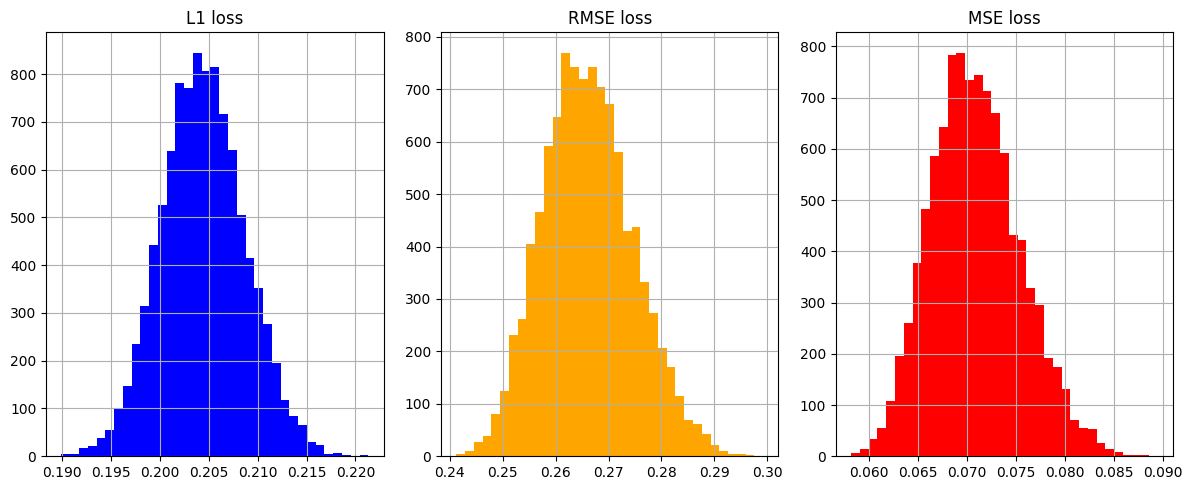

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution_scaled['l1'].hist(bins=35, ax=ax[0], color='blue')
df_benchmark_distribution_scaled['rmse'].hist(bins=35, ax=ax[1], color='orange')
df_benchmark_distribution_scaled['mse'].hist(bins=35, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

ANN #1 (con 25% di test-set)
- FOLD 1: 10.556
- FOLD 2: 9.7848
- FOLD 3: 9.8453
- FOLD 4: 9.5108

ANN #2 (con dataset orario - lo stesso che usa VQR)
- FOLD 1: 5.8584
- FOLD 2: 5.7268
- FOLD 3: 5.4658
- FOLD 4: 10.888

VQR Linear
- FOLD 1: 0.0082112
- FOLD 2: 0.0077559
- FOLD 3: 0.0065363
- FOLD 4: 0.0080037

VQR Non-linear
- FOLD 1: 0.010147
- FOLD 2: 0.0095828
- FOLD 3: 0.0094464
- FOLD 4: 0.011666

QLSTM (con il 30% di test-set)
- FOLD 1: 4.3070
- FOLD 2: 7.7299
- FOLD 3: 5.4600
- FOLD 4: 3.7013
- FOLD 5: 2.3611

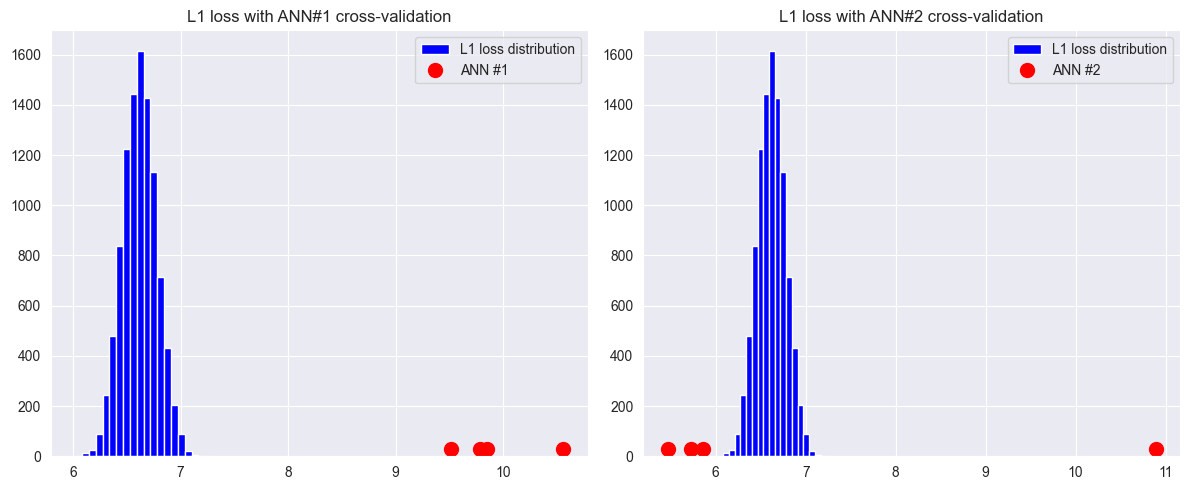

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax[0], color='blue', label='L1 loss distribution')
df_benchmark_distribution['l1'].hist(bins=20, ax=ax[1], color='blue', label='L1 loss distribution')
ax[0].set_title('L1 loss with ANN#1 cross-validation')
ax[1].set_title('L1 loss with ANN#2 cross-validation')
ax[0].plot([10.556, 9.7848, 9.8453, 9.5108], [30, 30, 30, 30], marker='.', ls='none', ms=20, color='red', label='ANN #1')
ax[1].plot([5.8584, 5.7268, 5.4658, 10.888], [30, 30, 30, 30], marker='.', ls='none', ms=20, color='red', label='ANN #2')
fig.tight_layout()
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
plt.show()

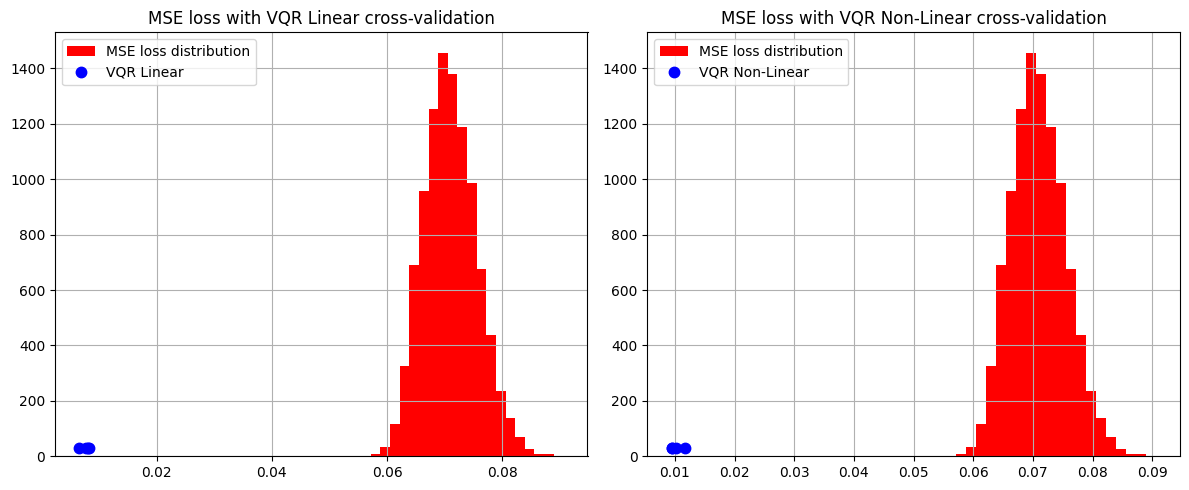

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_benchmark_distribution_scaled['mse'].hist(bins=20, ax=ax[0], color='red', label='MSE loss distribution')
df_benchmark_distribution_scaled['mse'].hist(bins=20, ax=ax[1], color='red', label='MSE loss distribution')
ax[0].set_title('MSE loss with VQR Linear cross-validation')
ax[1].set_title('MSE loss with VQR Non-Linear cross-validation')
ax[0].plot([0.0082112, 0.0077559, 0.0065363, 0.0080037], [30, 30, 30, 30], marker='.', ls='none', ms=15, color='blue', label='VQR Linear')
ax[1].plot([0.010147, 0.0095828, 0.0094464, 0.011666], [30, 30, 30, 30], marker='.', ls='none', ms=15, color='blue', label='VQR Non-Linear')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
fig.tight_layout()
plt.show()

### With 85% of test-set

In [12]:
TRAIN_SIZE      = 0.70

In [13]:
l1_loss = []
rmse_loss = []
mse_loss = []
for i in range(0, 10000):
    _, X_test, _, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=True)
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

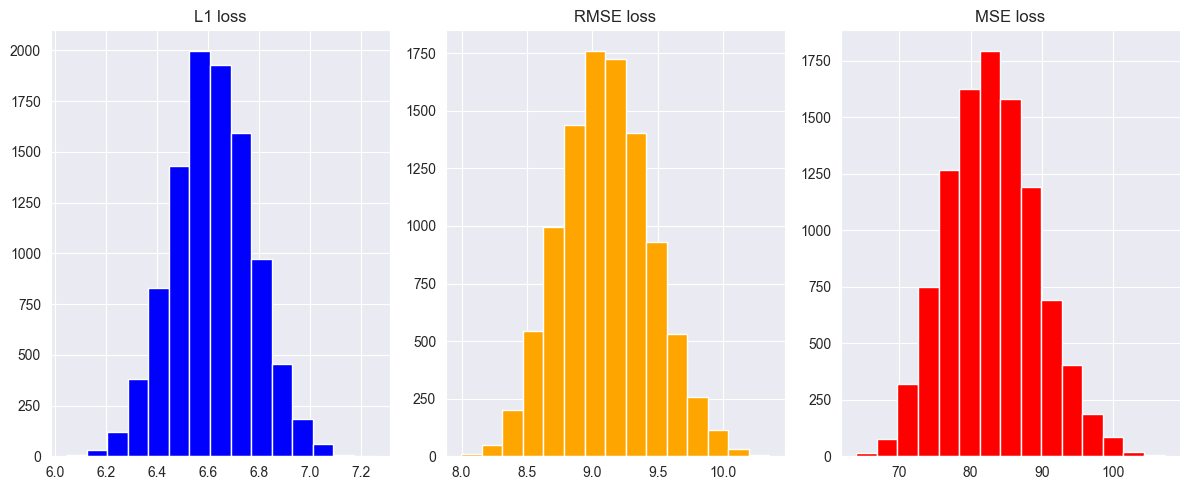

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=15, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=15, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=15, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

LSTM
- FOLD 1: 3.9884
- FOLD 2: 5.5502
- FOLD 3: 4.6265
- FOLD 4: 3.3922
- FOLD 5: 2.4122

LSTM-d
- FOLD 1: 4.4372
- FOLD 2: 7.2593
- FOLD 3: 5.5691
- FOLD 4: 3.5955
- FOLD 5: 2.5004

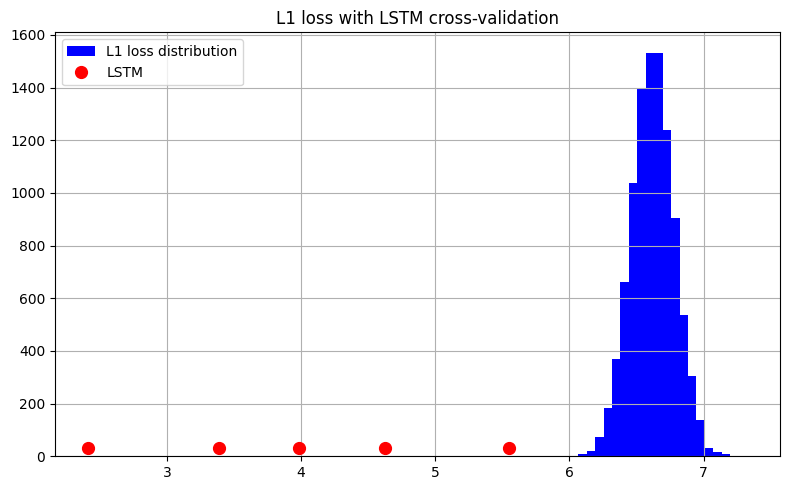

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax, color='blue', label='L1 loss distribution')
ax.set_title('L1 loss with LSTM cross-validation')
ax.plot([3.9884, 5.5502, 4.6265, 3.3922, 2.4122], [30, 30, 30, 30, 30], marker='.', ls='none', ms=17, color='red', label='LSTM')
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

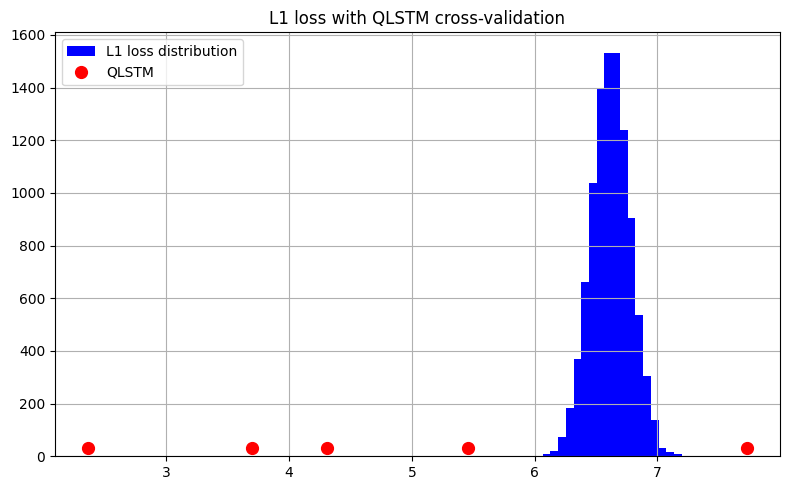

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax, color='blue', label='L1 loss distribution')
ax.set_title('L1 loss with QLSTM cross-validation')
ax.plot([4.3070, 7.7299, 5.4600, 3.7013, 2.3611], [30, 30, 30, 30, 30], marker='.', ls='none', ms=17, color='red', label='QLSTM')
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

Put LSTM and QLSTM together

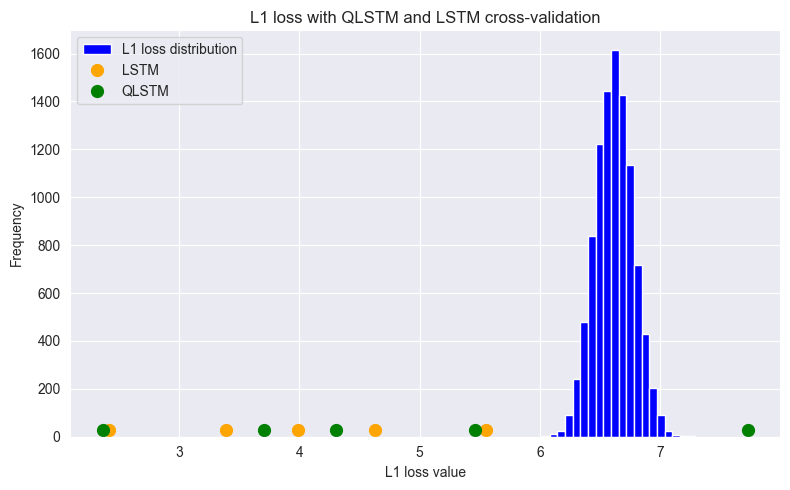

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax, color='blue', label='L1 loss distribution')
ax.set_title('L1 loss with QLSTM and LSTM cross-validation')
ax.plot([3.9884, 5.5502, 4.6265, 3.3922, 2.4122], [30, 30, 30, 30, 30], marker='.', ls='none', ms=17, color='orange', label='LSTM')
ax.plot([4.3070, 7.7299, 5.4600, 3.7013, 2.3611], [30, 30, 30, 30, 30], marker='.', ls='none', ms=17, color='green', label='QLSTM')
ax.set_ylabel('Frequency')
ax.set_xlabel('L1 loss value')
ax.legend(loc='upper left')
fig.tight_layout()
plt.savefig("lstm-qlstm-cv-result.svg", format='svg')
plt.show()

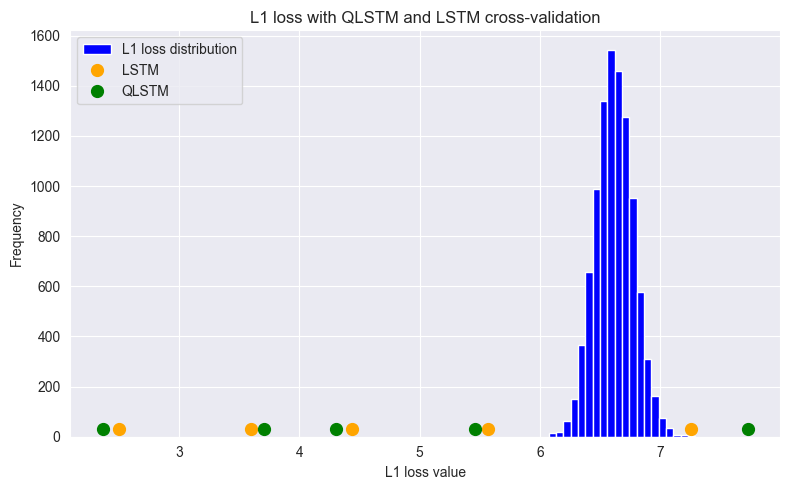

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax, color='blue', label='L1 loss distribution')
ax.set_title('L1 loss with QLSTM and LSTM cross-validation')
ax.plot([4.4372, 7.2593, 5.5691, 3.5955, 2.5004], [30, 30, 30, 30, 30], marker='.', ls='none', ms=17, color='orange', label='LSTM')
ax.plot([4.3070, 7.7299, 5.4600, 3.7013, 2.3611], [30, 30, 30, 30, 30], marker='.', ls='none', ms=17, color='green', label='QLSTM')
ax.set_ylabel('Frequency')
ax.set_xlabel('L1 loss value')
ax.legend(loc='upper left')
fig.tight_layout()
plt.savefig("lstm-qlstm-cv-result.svg", format='svg')
plt.show()

Make the same with ShuffleSplit library

In [97]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=10000, train_size=TRAIN_SIZE)
dataset = df[['x', 'y']]
l1_loss = []
rmse_loss = []
mse_loss = []

for _, test_index in ss.split(dataset):
    X_test = dataset.iloc[test_index].x.to_numpy()
    y_test = dataset.iloc[test_index].y.to_numpy()
    l1 = CRITERION_L1(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    rmse = CRITERION_RMSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    mse = CRITERION_MSE(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))).item()
    l1_loss.append(l1)
    rmse_loss.append(rmse)
    mse_loss.append(mse)

In [98]:
df_benchmark_distribution = pd.DataFrame(columns=['l1', 'rmse', 'mse'])
df_benchmark_distribution['l1'] = l1_loss
df_benchmark_distribution['rmse'] = rmse_loss
df_benchmark_distribution['mse'] = mse_loss

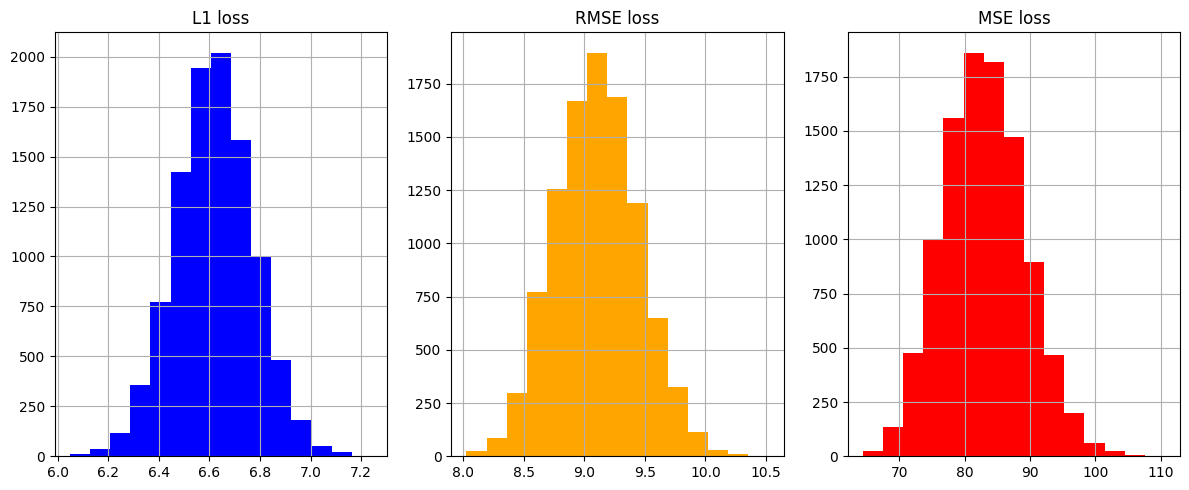

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
df_benchmark_distribution['l1'].hist(bins=15, ax=ax[0], color='blue')
df_benchmark_distribution['rmse'].hist(bins=15, ax=ax[1], color='orange')
df_benchmark_distribution['mse'].hist(bins=15, ax=ax[2], color='red')
ax[0].set_title('L1 loss')
ax[1].set_title('RMSE loss')
ax[2].set_title('MSE loss')
fig.tight_layout()
plt.show()

### ANN2 and VQR Linear

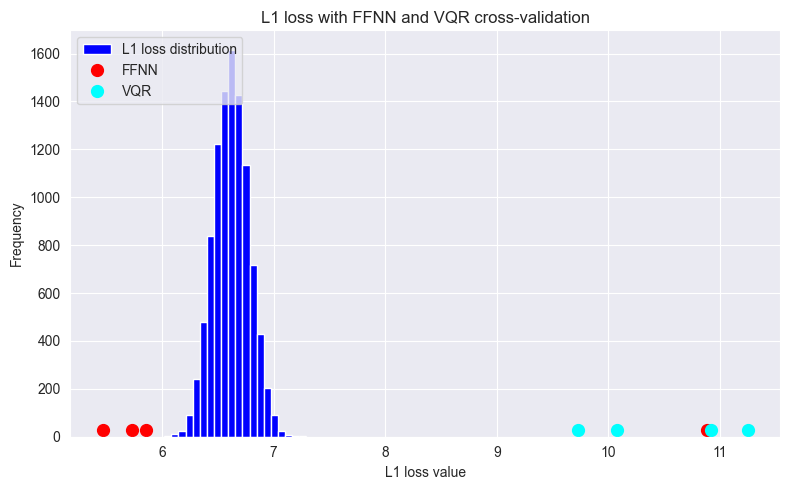

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_benchmark_distribution['l1'].hist(bins=20, ax=ax, color='blue', label='L1 loss distribution')
ax.set_title('L1 loss with FFNN and VQR cross-validation')

ax.plot([5.8584, 5.7268, 5.4658, 10.888], [30, 30, 30, 30], marker='.', ls='none', ms=17, color='red', label='FFNN')
ax.plot([11.2496, 10.9164, 9.7305, 10.0734], [30, 30, 30, 30], marker='.', ls='none', ms=17, color='cyan', label='VQR')
ax.set_ylabel('Frequency')
ax.set_xlabel('L1 loss value')
ax.legend(loc='upper left')
fig.tight_layout()
plt.savefig("ffnn-vqr-l1-cv-result.svg", format='svg')
plt.show()

In [ ]:
Loaded model: VQR_LINEAR_CV_FOLD1_2024-02-01_12-22.pt
FOLD 1
RMSE 13.7206002426857
MSE 188.25487101958691
L1 11.249608772743402
---
Loaded model: VQR_LINEAR_CV_FOLD2_2024-02-02_03-00.pt
FOLD 2
RMSE 13.563373392058837
MSE 183.96509777240965
L1 10.916450240551196
---
Loaded model: VQR_LINEAR_CV_FOLD3_2024-02-02_17-32.pt
FOLD 3
RMSE 11.95606003311143
MSE 142.9473715153645
L1 9.730520388817295
---
Loaded model: VQR_LINEAR_CV_FOLD4_2024-02-03_08-07.pt
FOLD 4
RMSE 13.089809038136085
MSE 171.34310065486915
L1 10.073401909799356
---
